In [55]:
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.ticker import FuncFormatter
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [5]:
KERNELS = ['linear', 'poly', 'rbf', 'sigmoid']

TARGETS = ['demand_target_bucket_1', 'demand_target_bucket_2', 'demand_target_bucket_6', 'demand_target_bucket_24']

In [53]:
FEATURES = ['trip_start_hour', 'trip_start_month',
       'trip_start_day', 'temp', 'humidity', 'wind_speed',
        'pressure', 'precip', 'Clear/Sunny',
       'Rain/Storms', 'Snow/Winter Conditions', 'temp_h-1', 'precip_h-1',
       'precip_h-2', 'autumn', 'spring', 'summer', 'winter', 'weekend',
       'afternoon_week', 'afternoon_weekend', 'evening_week',
       'evening_weekend', 'morning_week', 'morning_weekend', 'night_week',
       'night_weekend', 'is_holiday', 'demand_h-2', 'demand_h-24',
       'demand_p-24', 'demand_bucket_2', 'demand_bucket_6', 'demand_bucket_24',
       'catering', 'entertainment', 'transportation', 'healthcare', 'poi_sum',
       'is_airport', 'is_business_district']

# Helper Functions

In order to test several set ups of the SVM, these helper functions were constructed to be used repeatedly.

* `get_X_y`: Takes a dataframe and returns the respective X and y vectors based on the prediction horizon which shall be the target feature. All other prediction horizons won't be included in the dataframe
* `scale_data`: Scales the data X_test and X_train data. To avoid leakage, we use the fitted scaler of the training data as well for the test data
* `get_df_by_resolution`: Loads test and train data for a given resolution.

In [7]:
def get_X_y(df, prediction_horizon):
    y = df[f'demand_target_bucket_{prediction_horizon}']
    X = df[FEATURES +[f'pickup_demand_target_bucket_{prediction_horizon}']]

    return X, y

In [8]:
def scale_data(X_train, X_test=None):
    # Create the scaler
    scaler = StandardScaler()

    # Fit the scaler using the training data
    scaler.fit(X_train)

    # Transform both the training and test data
    X_train_scaled = scaler.transform(X_train)
    if X_test is not None: # Explicitly check against None
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled
    return X_train_scaled

In [51]:
def get_df_by_resolution(resolution, census=False):
    if census:
        df_train = pd.read_csv('./data/model_input/0_res_train.csv')
        df_test = pd.read_csv('./data/model_input/0_res_test.csv')
        return df_train, df_test

    df_train = pd.read_csv(f'./data/model_input/{resolution}_res_train.csv')
    df_test = pd.read_csv(f'./data/model_input/{resolution}_res_test.csv')
    return df_train, df_test

# Model Building
In this section, the SVM model's are built by first identifying a suitable `max_iter`, then the best `kernel` and in the end we use gridsearch to determine the best SVM setup for each resolution-prediciton horizon pair. Overall, our output is 7 * 4 = 28 models, i.e for all 7 resolutions, we train an individual model for each of the prediction horizons.

## Dataset sizes
The documentation for `SVR` of sklearn states the following:

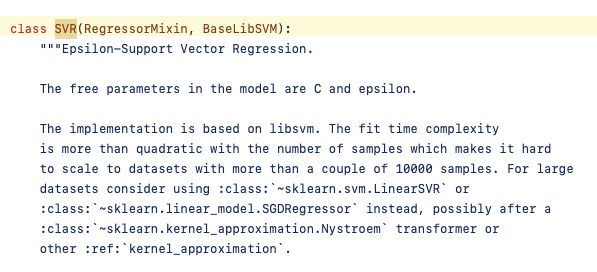

Hence, we checked for the number of rows for each resolution. The conclusion is that everything higher than resolution 5 barely makes sense with the standard SVR implementation. However as we want comparability, we did not want to use the `LinearSVR`, so we decided to try use `SVR` but by setting the `max_iter` parameter such that we do not optimize too long. We also decided to drop resolution 9, as it has a very similar number of rows than the census tract based dataset. Resolutions 1 and 3 were also dropped, as they do not seem to be identical to their successor resolutions.



In [ ]:
# Define the file names and labels for resolutions 1 to 9 plus 'census'
file_names = ['1_res_test', '2_res_test', '3_res_test', '4_res_test', '5_res_test', '6_res_test', '7_res_test', '8_res_test', '9_res_test', '0_res_test']
labels = [f'res_{name.split("_")[0]}' for name in file_names[:-1]] + ['census']

# Read the CSV files and get the lengths
lengths = [pd.read_csv(f'./data/model_input/{name}.csv').isna().sum().sum() for name in file_names]

# Plot the bar graph
bars = plt.bar(labels, lengths)
plt.xlabel('Dataframe Resolutions')
plt.ylabel('Number of rows')
plt.title('Number of rows')
plt.xticks(rotation=45)

# Format y-axis with commas
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Annotate the bars for df_3, df_4, df_5, and df_6 (you can change the range if you want specific annotations)
for i, bar in enumerate(bars[:10]):
    yval = bar.get_height()

    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom')

plt.show()

## Identify Best Kernel
As we have identiefied above, that everything above resolution 5 is hardly computable with a non-linear kernel, we conduct kernel evaluation only for resolutions 2,4,5. This is done by a gridsearch with 2-fold Cross Validation, hence a validation set is not needed. We tested the kernels only for prediction horizon 1 in order to save computation time and reduce evaluation complexity. Testing kernels for other prediction horizons is not necessary, as this would just mean changing the target feature, i.e. the data structure would not change hence we would obtain similar results.

**Finding:** As visible in the chart below, the linear kernel, performs best for all resolutions. This is why we will now go ahead and use `kernel='linear'` in the following process.

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.7s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.7s
[CV] END .................................C=1, kernel=linear; total time=   0.7s
[CV] END .................................C=1, kernel=linear; total time=   0.7s
[CV] END ................................C=10, kernel=linear; total time=   0.8s
[CV] END ................................C=10, kernel=linear; total time=   0.7s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.8s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.7s
[CV] END ..........C=0.1, degree=3, gamma=scale, kernel=poly; total time=   0.7s
[CV] END ..........C=0.1, degree=3, gamma=scale, kernel=poly; total time=   0.7s
[CV] END ............C=1, degree=2, gamma=scale, kernel=poly; total time=   1.2s
[CV] END ............C=1, degree=2, gamma=scale,

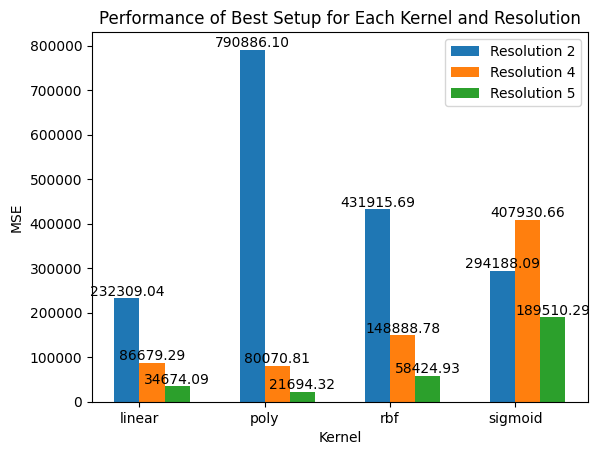

In [54]:
resolutions = [2,4,5]
horizon = 1

# Define hyperparameter grid for each kernel
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3], 'gamma': ['scale']},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['auto', 'scale']},
    {'kernel': ['sigmoid'], 'C': [0.1, 1, 10], 'gamma': ['auto']}
]

KERNELS = ['linear', 'poly', 'rbf', 'sigmoid']
results = {kernel: [] for kernel in KERNELS}

# Loop over resolutions
for resolution in resolutions:
    df_train, _ = get_df_by_resolution(resolution)
    X_train, y_train = get_X_y(df_train, horizon)
    X_train_scaled = scale_data(X_train)

    # Create GridSearchCV object
    grid_search = GridSearchCV(SVR(), param_grid, cv=2, verbose=2, scoring='neg_mean_squared_error')

    # Perform grid search
    grid_search.fit(X_train_scaled, y_train)

    # Extract the results
    cv_results = grid_search.cv_results_

    # Iterate over the kernels to find the best score for each
    for kernel in KERNELS:
        kernel_mask = [param['kernel'] == kernel for param in cv_results['params']]
        kernel_scores = cv_results['mean_test_score'][kernel_mask]
        best_kernel_score = max(kernel_scores)
        results[kernel].append(best_kernel_score)

# Plotting
bar_width = 0.2
index = np.arange(len(KERNELS))

for i, resolution in enumerate(resolutions):
    bar_values = [abs(results[kernel][i]) for kernel in KERNELS]
    bars = plt.bar(index + i * bar_width, bar_values, width=bar_width, label=f"Resolution {resolution}")

    # Annotate the bars with the absolute scores
    for bar, value in zip(bars, bar_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{abs(value):.2f}', ha='center', va='bottom')

plt.xlabel('Kernel')
plt.ylabel('MSE')
plt.title('Performance of Best Setup for Each Kernel and Resolution')
plt.xticks(index + bar_width / 2, KERNELS)
plt.legend()
plt.show()


## Identify Maximum Iteration
As we have previously found out, the `linear` kernel seems to outperform all other kernels. Hence we will use `LinearSVM` in the following parts. Before finally training the 28 models, we first have to find optimal `max_iter` parameters for the models with resolution 6,7,8 and census tract in order to not run in to long training time. We do this again by trying a simple SVR with default parameters and visually determine for each resolution the the perfect `max_iter` by analysing the ellbow functions.

From the elbow functions, we can conclude the following:
* Resolution 6: `max_iter=5000`
* Resolution 7: `max_iter=500`
* Resolution 8: `max_iter=300`
* Resolution census tract: `max_iter=1000`

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END .......................................max_iter=100; total time=   1.9s
[CV] END .......................................max_iter=100; total time=   1.4s
[CV] END .......................................max_iter=200; total time=   2.4s
[CV] END .......................................max_iter=200; total time=   2.3s
[CV] END .......................................max_iter=300; total time=   3.5s
[CV] END .......................................max_iter=300; total time=   5.5s
[CV] END .......................................max_iter=400; total time=   4.6s
[CV] END .......................................max_iter=400; total time=   5.0s
[CV] END .......................................max_iter=500; total time=   6.2s
[CV] END .......................................max_iter=500; total time=   5.6s
[CV] END ......................................max_iter=1000; total time=  12.2s
[CV] END ......................................ma

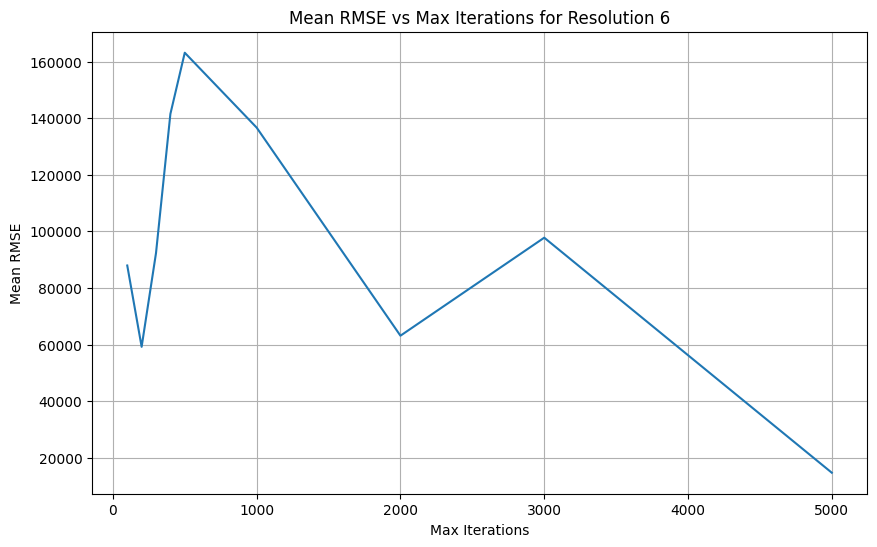

Best parameters for Resolution 6: {'max_iter': 5000}
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END .......................................max_iter=100; total time=   5.5s
[CV] END .......................................max_iter=100; total time=   7.2s
[CV] END .......................................max_iter=200; total time=  13.0s
[CV] END .......................................max_iter=200; total time=  11.0s
[CV] END .......................................max_iter=300; total time=  15.3s
[CV] END .......................................max_iter=300; total time=  14.9s
[CV] END .......................................max_iter=400; total time=  20.4s
[CV] END .......................................max_iter=400; total time=  19.9s
[CV] END .......................................max_iter=500; total time=  25.4s
[CV] END .......................................max_iter=500; total time=  25.3s
[CV] END ......................................max_iter=1000; total time=  51

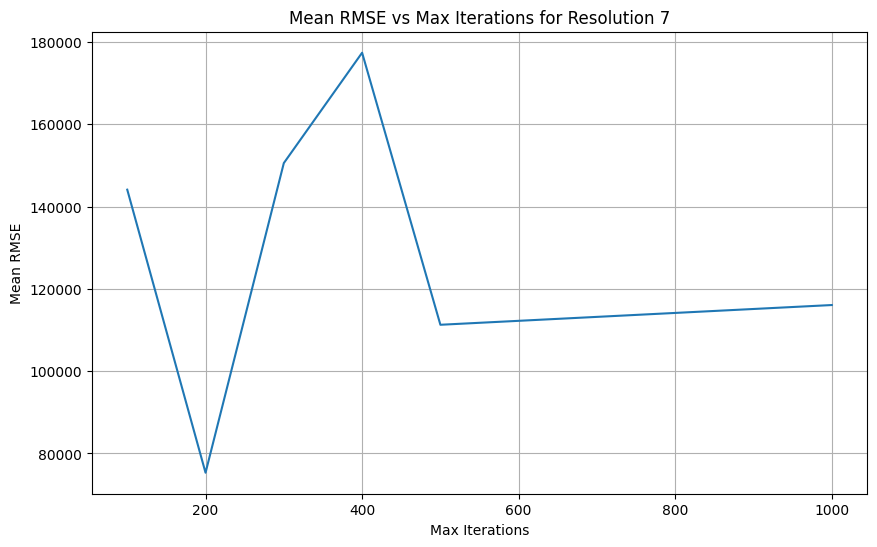

Best parameters for Resolution 7: {'max_iter': 200}
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END .......................................max_iter=100; total time=  17.3s
[CV] END .......................................max_iter=100; total time=  16.0s
[CV] END .......................................max_iter=200; total time=  31.3s
[CV] END .......................................max_iter=200; total time=  30.9s
[CV] END .......................................max_iter=300; total time=  47.8s
[CV] END .......................................max_iter=300; total time=  45.8s
[CV] END .......................................max_iter=400; total time= 1.0min
[CV] END .......................................max_iter=400; total time= 1.0min
[CV] END .......................................max_iter=500; total time= 1.3min
[CV] END .......................................max_iter=500; total time= 1.3min
[CV] END ......................................max_iter=1000; total time= 2.6m

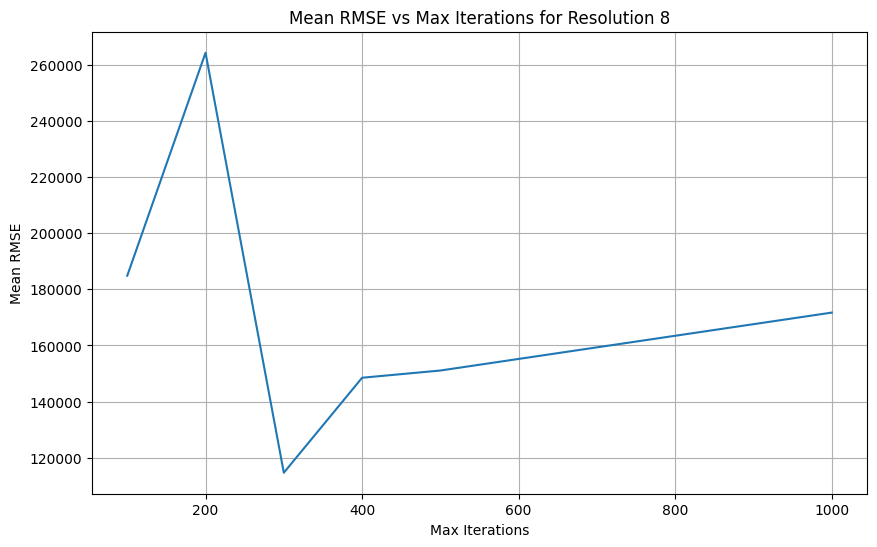

Best parameters for Resolution 8: {'max_iter': 300}
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END .......................................max_iter=100; total time=  22.9s
[CV] END .......................................max_iter=100; total time=  23.4s
[CV] END .......................................max_iter=200; total time=  44.1s
[CV] END .......................................max_iter=200; total time=  43.4s
[CV] END .......................................max_iter=300; total time= 1.1min
[CV] END .......................................max_iter=300; total time= 1.1min
[CV] END .......................................max_iter=400; total time= 1.4min
[CV] END .......................................max_iter=400; total time= 1.5min
[CV] END .......................................max_iter=500; total time= 1.8min
[CV] END .......................................max_iter=500; total time= 1.8min
[CV] END ......................................max_iter=1000; total time= 3.6m

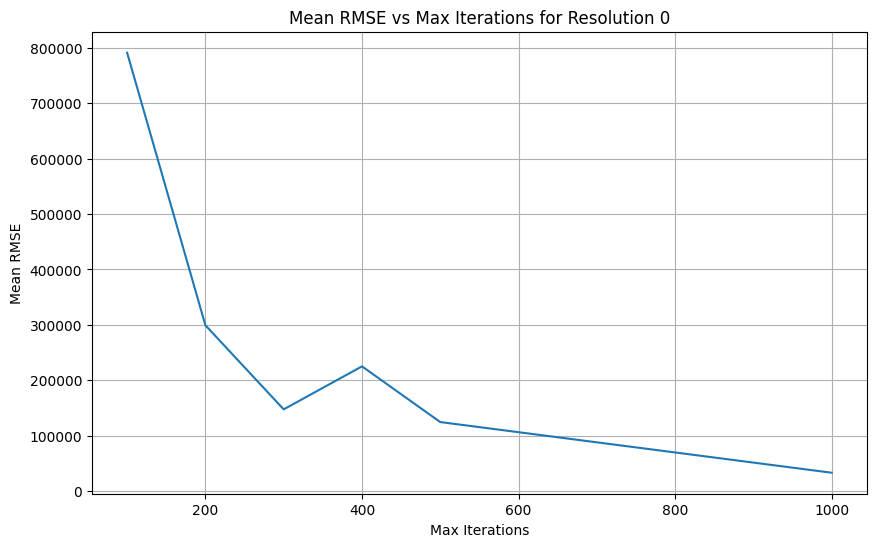

Best parameters for Resolution 0: {'max_iter': 1000}


In [56]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
def optimize_max_iter_for_svr(resolution, param_grid):
    df_train, _ = get_df_by_resolution(resolution)
    X_train, y_train = get_X_y(df_train, 1)
    X_train_scaled = scale_data(X_train)

    # Create a GridSearchCV object
    grid_search = GridSearchCV(SVR(kernel='linear'), param_grid, cv=2, verbose=2, scoring='neg_mean_squared_error')

    # Fit the model
    grid_search.fit(X_train_scaled, y_train)

    # Get results
    cv_results = grid_search.cv_results_
    mean_scores = cv_results['mean_test_score']
    max_iters = [p['max_iter'] for p in cv_results['params']]

    # Plot the mean RMSE for each max_iter value
    plt.figure(figsize=(10,6))
    plt.plot(max_iters, [-score for score in mean_scores])
    plt.xlabel('Max Iterations')
    plt.ylabel('Mean RMSE')
    plt.title(f'Mean RMSE vs Max Iterations for Resolution {resolution}')
    plt.grid(True)
    plt.show()

    # Print the best parameters
    print(f"Best parameters for Resolution {resolution}: {grid_search.best_params_}")

for res in [6,7,8, 0 ]:
  if res == 6:

    param_grid = [
          {'max_iter':[100, 200, 300, 400, 500, 1000, 2000, 3000, 5000]}
      ]
  else:
    param_grid = [
          {'max_iter':[100, 200, 300, 400, 500, 1000]}
    ]

  optimize_max_iter_for_svr(res, param_grid)


## Training the final models
Now we train for on each of the 6 resolutions 4 different target horizons, such that we end up with 6*4 =24 models. As previously mentioned we do restirct the maximum iterations for the resolutions 7, 8 and census tract, as this would otherwise take too long to converge.

In [ ]:
RESOLUTIONS = [2, 4, 5, 6, 7, 8, 0]
TARGET_HORIOZONS = [1, 2, 6, 24]

results = []
for resolution in RESOLUTIONS:
    rmse_per_horizon = []
    r2_per_horizon = []
    for horizon in TARGET_HORIOZONS:
        print(f'RESOLUTION:{resolution} - HORIZON: {horizon}')
        # Get and preprocess data
        df_train, df_test = get_df_by_resolution(resolution)
        X_train, y_train = get_X_y(df_train, horizon)
        X_test, y_test = get_X_y(df_test, horizon)
        X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
        print(f'Data loaded!')

        model_path = f'./data/SVM_checkpoints/{resolution}_res_{horizon}_target.pkl'
        if os.path.exists(model_path):

          print(f"Loading model from {model_path}...")
          with open(model_path, 'rb') as file:
            best_model = pickle.load(file)
          print("Model loaded successfully.")
        else:

          param_grid = [
              {'kernel': ['linear'], 'C': [0.1, 1, 10]}
          ]

          if resolution in [6, 7, 8, 0]:
              if resolution == 6:
                  max_iter = 5000
              elif resolution == 7:
                  max_iter = 500
              elif resolution == 8:
                  max_iter = 300
              elif resolution == 0:
                  max_iter = 1000

              param_grid = [
                  {'kernel': ['linear'], 'C': [0.1, 1, 10], 'max_iter': [max_iter]}
              ]

          print(f'Start Grid Search')
          grid_search = GridSearchCV(SVR(), param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=2)
          grid_search.fit(X_train_scaled, y_train)
          print(f'End fit')

          best_params = grid_search.best_params_

          # Create a new SVR model with the best hyperparameters
          best_model = SVR(**best_params)
          # Fit the new model using the training data
          best_model.fit(X_train_scaled, y_train)
          # Use the newly fitted model to make predictions

        with open(model_path, "wb") as file:
          pickle.dump(best_model, file)

        y_pred = best_model.predict(X_test_scaled)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)

        mae = mean_absolute_error(y_test, y_pred)

        # Calculate R2
        r2 = r2_score(y_test, y_pred)

        # Store results
        results.append([resolution, horizon, mse, mae, r2])
        pd.DataFrame(results, columns=['resolution', 'horizon', 'mse', 'mae' 'r2']).to_csv('./data/results/svm_results.csv')

# Creating a DataFrame from the reshaped matrix
df = pd.DataFrame(results, columns=['resolution', 'horizon', 'mse', 'mae', 'r2'])
df.to_csv('./data/results/svm_results.csv')

RESOLUTION:5 - HORIZON: 6
Data loaded!
Start Grid Search
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...............................C=0.1, kernel=linear; total time= 1.6min
